# Convolutional Autoencoder on STL-10 Color Images using PyTorch

In [1]:
# -----------------------------
# 1. Import required libraries
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# -----------------------------
# 2. Define transformations for STL-10 dataset
# -----------------------------
# We resize to 64x64 to make the model smaller/faster to train.
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # scale to [-1,1]
])

In [3]:
# -----------------------------
# 3. Load the dataset
# -----------------------------
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


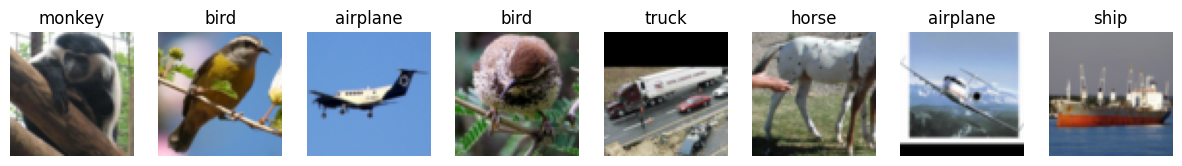

In [4]:
# -----------------------------
# 4. Visualize some training images
# -----------------------------

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

def plot_examples(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15,3))
    for idx, ax in enumerate(axes):
        image = (images[idx].squeeze() + 1) / 2
        image = np.transpose(image, (1, 2, 0))
        ax.imshow(image)
        ax.set_title(f"{classes[labels[idx]]}")
        ax.axis('off')
    plt.show()

# Show images
plot_examples(images[:8], labels[:8])

In [15]:
# -----------------------------
# 3. Define Encoder and Decoder separately
# -----------------------------
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 64x32x32
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 128x16x16
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 256x8x8
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 512x4x4
            nn.ReLU(True),
        )
    
    def forward(self, x):
        return self.conv_layers(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 256x8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 128x16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 64x32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),    # 3x64x64
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.deconv_layers(z)

# Full autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = Autoencoder()

In [16]:
# -----------------------------
# 4. Loss function and optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# -----------------------------
# 5. Training loop
# -----------------------------
num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, _ in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(test_loader):
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    test_losses.append(val_loss / len(test_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.1749, Test Loss: 0.0975


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.0813, Test Loss: 0.0726


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.0655, Test Loss: 0.0681


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.0578, Test Loss: 0.0535


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.0492, Test Loss: 0.0428


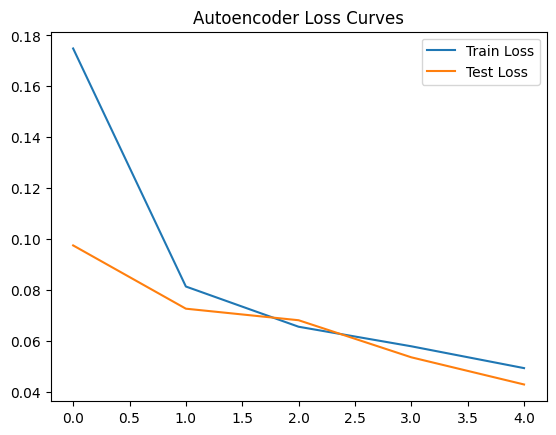

In [18]:
# -----------------------------
# 6. Plot loss curves
# -----------------------------
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Autoencoder Loss Curves")
plt.show()

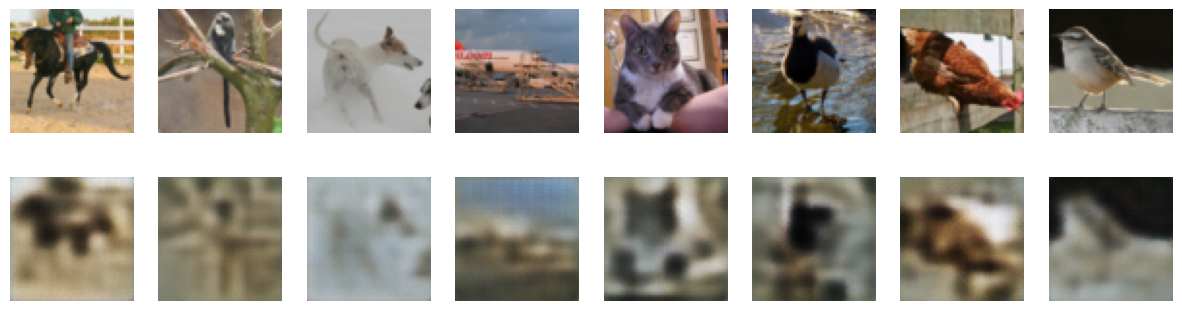

In [19]:
model.eval()
images, _ = next(iter(test_loader))

with torch.no_grad():
    reconstructions = model(images)
    
fig, axes = plt.subplots(2, 8, figsize=(15,4))
for i in range(8):
    image = np.transpose(images[i].numpy(), (1,2,0))
    image = (image + 1) /2
    axes[0,i].imshow(image)
    axes[0,i].axis('off')
    reconstruction = np.transpose(reconstructions[i].numpy(), (1,2,0))
    reconstruction = (reconstruction + 1) /2
    axes[1,i].imshow(reconstruction)
    axes[1,i].axis('off')
axes[0,0].set_ylabel("Original", fontsize=12)
axes[1,0].set_ylabel("Reconstructed", fontsize=12)
plt.show()

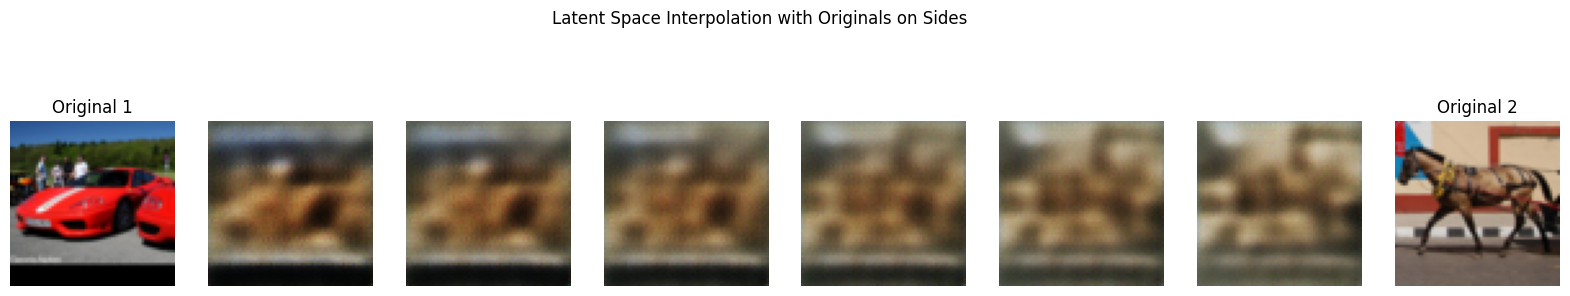

In [23]:
# -----------------------------
# 8. Latent space interpolation between two images
# -----------------------------
model.eval()

# Randomly pick two indices from the test set
idx = np.random.choice(len(test_dataset), size=2, replace=False)
img1, _ = test_dataset[idx[0]]
img2, _ = test_dataset[idx[1]]

# Add batch dimension: shape [1,3,64,64]
img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)

with torch.no_grad():
    # Encode both images
    z1 = model.encoder(img1)
    z2 = model.encoder(img2)

    # Interpolate in latent space: 6 steps in between
    steps = 6
    interpolated = []
    for alpha in np.linspace(0, 1, steps+2)[1:-1]:  # skip 0 and 1 (originals)
        z_interp = (1-alpha)*z1 + alpha*z2
        interpolated.append(z_interp)

    # Decode interpolated vectors
    reconstructions = [model.decoder(z) for z in interpolated]

# Visualize: original + interpolations + original
fig, axes = plt.subplots(1, steps+2, figsize=(20,4))

# Left original
img1 = np.transpose(img1[0].numpy(), (1,2,0))
img1 = (img1 + 1) /2
axes[0].imshow(img1)
axes[0].set_title("Original 1")
axes[0].axis('off')

# Interpolated images
for i in range(steps):
    reconstruction = np.transpose(reconstructions[i][0].numpy(), (1,2,0))
    reconstruction = (reconstruction + 1) /2
    axes[i+1].imshow(reconstruction)
    axes[i+1].axis('off')

# Right original
img2 = np.transpose(img2[0].numpy(), (1,2,0))
img2 = (img2 + 1) /2
axes[-1].imshow(img2)
axes[-1].set_title("Original 2")
axes[-1].axis('off')

plt.suptitle("Latent Space Interpolation with Originals on Sides")
plt.show()